### Analyzing "Medical Appointment No Shows"


#### This notebook will visualize what information is content in the health appointments and the relation with no show events. 
#### There is some variables that can be useful to understand what makes (or not) to people from attend or not to their health appointments. In this notebook, you will visualize those behaviour along with some conclusions about that.
#### There is some problems with the age field, so this code handle that data wranglid, but in general there is no nan values or similar

In [1]:
print ("-"*80)

--------------------------------------------------------------------------------


## There is some questions that emerge from simple data inspecting through the variables
#### Research questions:
#### - Is Age variable, making any difference on no-show data?
#### - Maybe women are more conscient of their health issues?
#### - Is the scholarship making to people take care of their health, showing more often in the appointments?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import time

%matplotlib inline

pd.options.display.max_rows = 200

ns = pd.read_csv("KaggleV2-May-2016.csv")


In [5]:
display (ns.head())
display (ns.shape)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


(110527, 14)

In [6]:
display( ns.describe())
display( ns["No-show"].describe())
display( ns["No-show"].value_counts())


,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


count     110527
unique         2
top           No
freq       88208
Name: No-show, dtype: object

No     88208
Yes    22319
Name: No-show, dtype: int64

In [7]:
ns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


### Note: 
Do not have null values in any of the columns, so we skip the fillna step

## 1. First, will graph numerical variables to see how scattered are the data

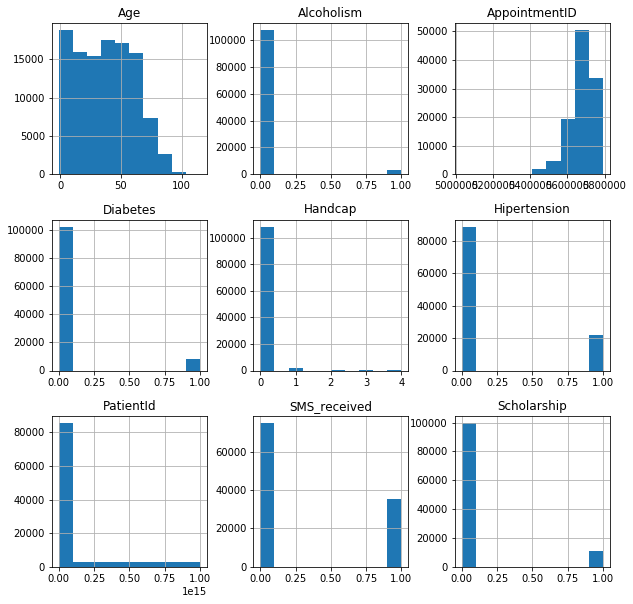

In [8]:
ns.hist(figsize=(10,10));

### No show variable is categorical, will transform to numerical through a function, and then graph this variable itself

In [9]:
#Transform No Show variable (target) to numeric
def noshow_num(var):
    if var == "Yes":
        NS = 1
    else:
        NS = 0
    return NS

ns["NS"] = ns["No-show"].apply(noshow_num)
ns.drop("No-show", axis=1, inplace = True)


0    79.806744
1    20.193256
Name: NS, dtype: float64

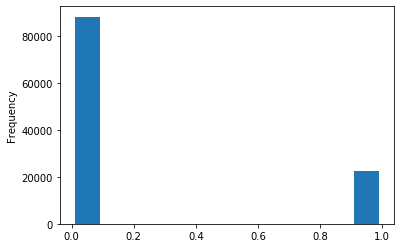

In [10]:
ns["NS"].plot.hist(bins= 10, rwidth = 0.8)
ns["NS"].value_counts(normalize=True).sort_index()*100


Around 20% of the data has a "no-show" value and the remaining 80% effectively attends to their health appointment

## 2. Drop some columns and create new ones
- Not using AppointmentID 
- Keep PatientID just to analyze some cases if necessary 
- From dates of appointment, will create new fields, like year, month, and day of the week
- Create a new field called Distance (in days), from schedule and appointment, want to see if urgent or programmed health examination makes a difference
- Inspect Age variable to validate that values are correct

In [11]:
# Dates come in string format, need to select partial text to create new variables
# Example: 2016-04-29T18:38:08Z

ns["Date_Scheduled"] = pd.to_datetime(ns["ScheduledDay"].str.slice(start=0, stop = 10), format = "%Y-%m-%d")
ns["Date_Appointment"] = ns["AppointmentDay"].astype('datetime64[ns]')

ns["distance"] = (ns["Date_Appointment"] - ns["Date_Scheduled"]).dt.days

ns["year_scheduled"] = ns['ScheduledDay'].str.slice(start = 0, stop = 4).astype(int)
ns["month_scheduled"] = ns['ScheduledDay'].str.slice(start = 6, stop = 7).astype(int)
ns["day_scheduled"] = ns['ScheduledDay'].str.slice(start = 9, stop = 10).astype(int)

ns["year_appointment"] = ns['AppointmentDay'].str.slice(start = 0, stop = 4).astype(int)
ns["month_appointment"] = ns['AppointmentDay'].str.slice(start = 6, stop = 7).astype(int)
ns["day_appointment"] = ns['AppointmentDay'].str.slice(start = 9, stop = 10).astype(int)



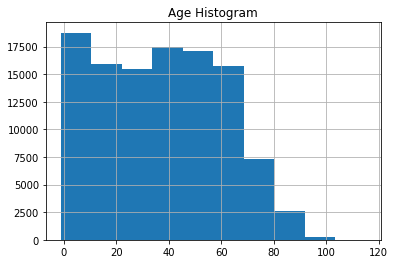

In [28]:
# Inspect Age variable
ns["Age"].hist()
plt.title('Age Histogram');

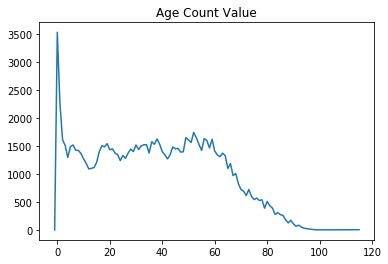

In [30]:
age_data = ns["Age"].value_counts().sort_index(ascending = True)
#display(age_data)
plt.plot(age_data)
plt.title('Age Count Value');

In [15]:
avg_age = np.nanmean(ns["Age"])
#print("Average age is "  + str(avg_age))
print("Average age is "+ str(avg_age))

Average age is 37.08887421173107


Average age is 37.08887421173107


-1         1
 0      3539
 1      2273
 2      1618
 3      1513
 4      1299
 5      1489
 6      1521
 7      1427
 8      1424
 9      1372
 10     1274
 11     1195
 12     1092
 13     1103
 14     1118
 15     1211
 16     1402
 17     1509
 18     1487
 19     1545
 20     1437
 21     1452
 22     1376
 23     1349
 24     1242
 25     1332
 26     1283
 27     1377
 28     1448
 29     1403
 30     1521
 31     1439
 32     1505
 33     1524
 34     1526
 35     1378
 36     1580
 37     1533
 38     1629
 39     1536
 40     1402
 41     1346
 42     1272
 43     1344
 44     1487
 45     1453
 46     1460
 47     1394
 48     1399
 49     1652
 50     1613
 51     1567
 52     1746
 53     1651
 54     1530
 55     1425
 56     1635
 57     1603
 58     1469
 59     1624
 60     1411
 61     1343
 62     1312
 63     1374
 64     1331
 65     1101
 66     1187
 67      973
 68     1012
 69      832
 70      724
 71      695
 72      615
 73      725
 74      602
 75      544

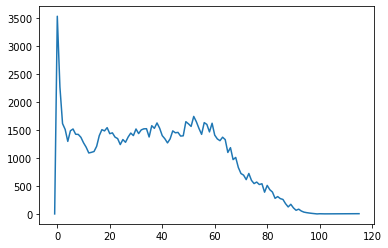

In [16]:
print("Average age is "+ str(np.mean(ns["Age"])))
age_data_fixed = ns["Age"].value_counts().sort_index(ascending = True)
display(age_data_fixed)
plt.plot(age_data_fixed)

### Create 2 variables (show, no-show), to make it easier to graph how the independent variables moves along the attendance

In [17]:
show = ns.NS == False
no_show = ns.NS == True


#print ( ns.Age[show].mean() )
#print ( ns.Age[no_show].mean() )


### Research question: Is Age variable, making any difference on no-show data?

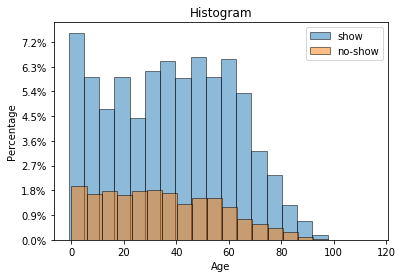

In [18]:
#Attendance histogram along age

fig, ax = plt.subplots()
ax.hist(ns.Age[show], bins = 20, alpha = 0.5, label="show", edgecolor='black')
ax.hist(ns.Age[no_show], bins = 20, alpha = 0.5, label="no-show", edgecolor='black')
ax.set_title("Histogram")
ax.set_xlabel("Age")
ax.set_ylabel("Percentage")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(ns)))
plt.legend();


#### Conclusion: Younger people has more no-show events compared with older ones

### Research question: Is Gender variable, making any difference on no-show data?

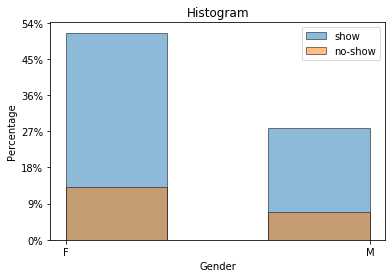

In [20]:
#Attendance histogram along gender

fig, ax = plt.subplots()
ax.hist(ns.Gender[show], bins = 3, alpha = 0.5, label="show", edgecolor='black')
ax.hist(ns.Gender[no_show], bins = 3, alpha = 0.5, label="no-show", edgecolor='black')
ax.set_title("Histogram")
ax.set_xlabel("Gender")
ax.set_ylabel("Percentage")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(ns)))
plt.legend();

#### Conclusion about gender: Female people has more no-show events compared to men, maybe them has more problems attending to their appointments

### Research question: Is distance variable, making any difference on no-show data?

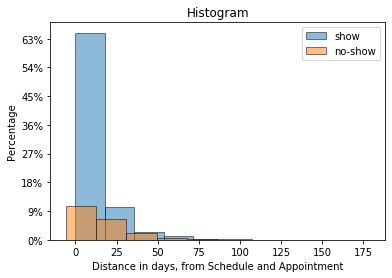

In [21]:
#Attendance histogram along distance from scheduling and appointment

fig, ax = plt.subplots()
ax.hist(ns.distance[show], bins = 10, alpha = 0.5, label="show", edgecolor='black')
ax.hist(ns.distance[no_show], bins = 10, alpha = 0.5, label="no-show", edgecolor='black')
ax.set_title("Histogram")
ax.set_xlabel("Distance in days, from Schedule and Appointment")
ax.set_ylabel("Percentage")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(ns)))
plt.legend();

#### Conclusion: I'm considering that when are a few days from schedule to appointment date, we're talking about an emergency or complex health issue. From day 25 and more, those cases are programmed revision or check of health status. There is a lot of show status in the urgency appointments (about 63%), but there is a considering no-show events, and similar to the "show" ones, between 8% and 9%.

### Research question: Is scholarship variable, making any difference on no-show data?

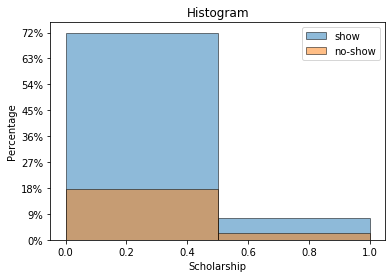

In [24]:
## Attendance histogram along Scholarship

fig, ax = plt.subplots()
ax.hist(ns.Scholarship[show], bins = 2, alpha = 0.5, label="show", edgecolor='black')
ax.hist(ns.Scholarship[no_show], bins = 2, alpha = 0.5, label="no-show", edgecolor='black')
ax.set_title("Histogram")
ax.set_xlabel("Scholarship")
ax.set_ylabel("Percentage")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(ns)))
plt.legend();

#### Conclusion: People without scholarship support has higher amount of no-show appointments. 

#### Analyze another variables from the dataset

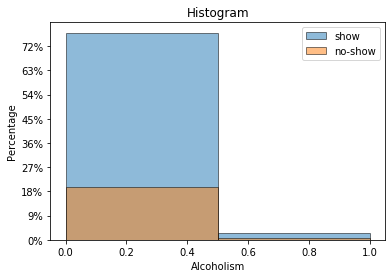

In [22]:
#Attendance histogram along alcoholism

fig, ax = plt.subplots()
ax.hist(ns.Alcoholism[show], bins = 2, alpha = 0.5, label="show", edgecolor='black')
ax.hist(ns.Alcoholism[no_show], bins = 2, alpha = 0.5, label="no-show", edgecolor='black')
ax.set_title("Histogram")
ax.set_xlabel("Alcoholism")
ax.set_ylabel("Percentage")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(ns)))
plt.legend();

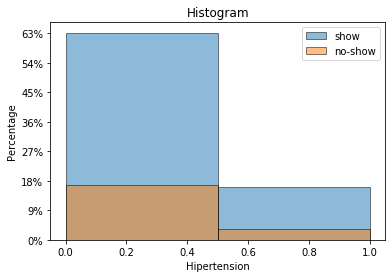

In [37]:
#Attendance histogram along Hipertension

fig, ax = plt.subplots()
ax.hist(ns.Hipertension[show], bins = 2, alpha = 0.5, label="show", edgecolor='black')
ax.hist(ns.Hipertension[no_show], bins = 2, alpha = 0.5, label="no-show", edgecolor='black')
ax.set_title("Histogram")
ax.set_xlabel("Hipertension")
ax.set_ylabel("Percentage")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(ns)))
plt.legend();

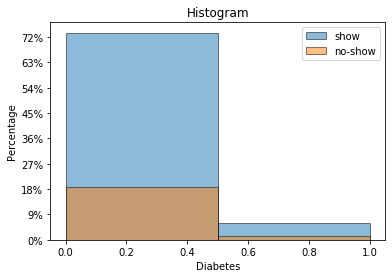

In [36]:
#Attendance histogram along Diabetes

fig, ax = plt.subplots()
ax.hist(ns.Diabetes[show], bins = 2, alpha = 0.5, label="show", edgecolor='black')
ax.hist(ns.Diabetes[no_show], bins = 2, alpha = 0.5, label="no-show", edgecolor='black')
ax.set_title("Histogram")
ax.set_xlabel("Diabetes")
ax.set_ylabel("Percentage")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(ns)))
plt.legend();

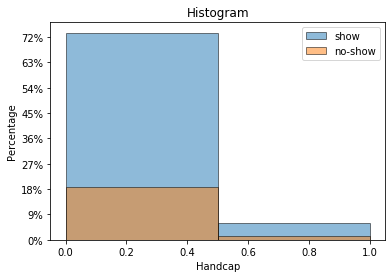

In [35]:
#Attendance histogram along Handcap

fig, ax = plt.subplots()
ax.hist(ns.Diabetes[show], bins = 2, alpha = 0.5, label="show", edgecolor='black')
ax.hist(ns.Diabetes[no_show], bins = 2, alpha = 0.5, label="no-show", edgecolor='black')
ax.set_title("Histogram")
ax.set_xlabel("Handcap")
ax.set_ylabel("Percentage")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(ns)))
plt.legend();

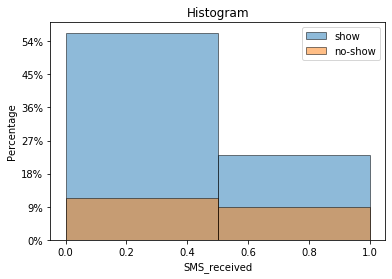

In [34]:
#Attendance histogram along SMS_received

fig, ax = plt.subplots()
ax.hist(ns.SMS_received[show], bins = 2, alpha = 0.5, label="show", edgecolor='black')
ax.hist(ns.SMS_received[no_show], bins = 2, alpha = 0.5, label="no-show", edgecolor='black')
ax.set_title("Histogram")
ax.set_xlabel("SMS_received")
ax.set_ylabel("Percentage")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(ns)))
plt.legend();

#### We can see that people with alcoholism, hipertension, diabetes and handcap is not making that a person make a no-show appointment.
#### People recieving a SMS notification has very similar percentage (about 9%) of no-show events. It can say that the notification to health appointments doesn't make any difference in those patients

#### Conclusions:
#### - The data set provided, was sufficient to find some insights, but I expected that some people health conditions expressed in the binary variables can show some difference on no-show appointments.
#### - The "distance" variable created from the provided data, help to understand the behaviour and differences when people are ill and need an urgency attention or regular health checking.